# Introduction
For my term project I would like to look at data from The Movies Dataset (https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv), specifically the
movies_metadata.csv file. They have data from 45,000 movies released on or before July 2017.
The dataset goes back to 1874 with Passage de Venus, and has popular movies from all time
periods including Gone with the Wind, The Wizard of Oz, and more recent films like Thor:
Ragnarok.

The metadata file I am interested in includes: genres, release_date, title, vote_average, and vote_count. There are more
descriptors but these are the only ones I’m interested in using.

## Motivation
I would like to understand the trends of genres over time. I am interested in this project because movies are a very popular media that most people have consumed. A lot of money is invested into creating movies each year, so I think it would be very interesting to look at what influences IMDB ratings and trends over time.

## Step 1 - reading and cleaning

In [44]:
import pandas as pd
import numpy as np
import json
import time
from datetime import datetime
import seaborn as sn
import copy

movies = pd.read_csv('./archive/movies_metadata.csv') 

# set columns names
movies = movies[['title', 'release_date', 'vote_average', 'vote_count', 'genres']]
movies = movies.dropna(axis=0)
movies = movies.reset_index()

# remove JSON formatting
movies['genres'] = movies['genres'].map(lambda x: x[1:-1].replace("\'", "\"").replace('},', "}},").split('},'))
for i in range(movies.shape[0]):
    temp = []
    for j in movies['genres'][i]:
        if j:
            line = json.loads(j)
            temp.append(line['name'])
        else:
            temp.append("None")
    movies['genres'][i] = temp.copy()

# change date formatting
for i in range(0, len(movies['release_date'])):
    movies['release_date'][i] = int(copy.deepcopy(movies['release_date'][i][0:4]))
    
## sort by, reset, drop
movies = movies.sort_values('release_date')
movies = movies.reset_index()
movies = movies.drop('index', 1)
movies = movies.drop('level_0', 1)
movies.head()

/Users/meganbooher/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-44-58b3326dcd69>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'][i] = temp.copy()
<ipython-input-44-58b3326dcd69>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['release_date'][i] = int(copy.deepcopy(movies['release_date'][i][0:4]))


,title,release_date,vote_average,vote_count,genres
0,Passage of Venus,1874,6.0,19.0,[Documentary]
1,Sallie Gardner at a Gallop,1878,6.2,25.0,[Documentary]
2,Buffalo Running,1883,5.4,7.0,[Documentary]
3,Man Walking Around a Corner,1887,4.1,17.0,[Documentary]
4,Accordion Player,1888,4.4,18.0,[Documentary]


## Step 2: Make graphs

### 2.1  First, I am interested in vote average over time and vote count over time

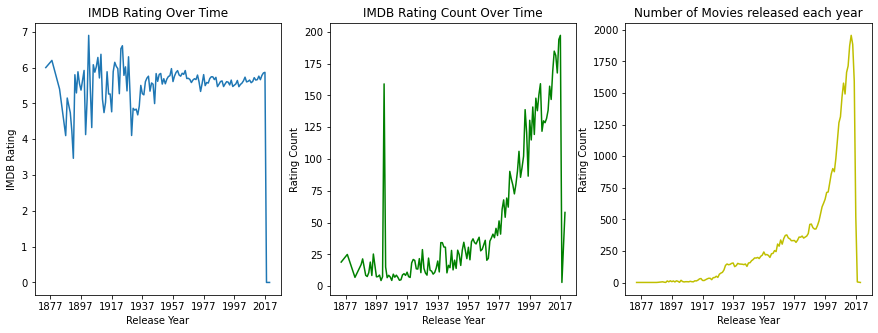

In [29]:
import matplotlib.pyplot as plt

# Create DF with aggregations
movies_avg = pd.DataFrame()
movies_avg['vote_average'] = movies.groupby('release_date')['vote_average'].mean()
movies_avg['vote_count'] = movies.groupby('release_date')['vote_count'].mean()
movies_avg['num_movies'] = movies.groupby('release_date')['title'].count()

## plot
plt.subplots(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(movies_avg.index, movies_avg['vote_average'])
plt.title('IMDB Rating Over Time')
plt.xlabel("Release Year")
plt.ylabel("IMDB Rating")
plt.xticks(range(1877, 2020, 20))

plt.subplot(1, 3, 2)
plt.plot(movies_avg.index, movies_avg['vote_count'], 'g')
plt.title('IMDB Rating Count Over Time')
plt.xlabel("Release Year")
plt.ylabel("Rating Count")
plt.xticks(range(1877, 2020, 20))

plt.subplot(1, 3, 3)
plt.plot(movies_avg.index, movies_avg['num_movies'], 'y')
plt.title('Number of Movies released each year')
plt.xlabel("Release Year")
plt.ylabel("Rating Count")
plt.xticks(range(1877, 2020, 20))
plt.show()

- The average rating over time is very jumpy from 1887 until around the 1940's. The 1940's is also when the number of ratings each year and number of movies each year starts to increase. 
- This leads me to believe that ratings are jumpy before 1940's because there were not enough votes or movies to create a consistent average.
- After the 1940's the average rating settles down to about 5.5, before that it is all over the palce.
- It looks like the movie data for the year 2017 are incomplete because of how low the number of movies becomes.
- There is a large jump in ratings for one year around 1900's, I wonder what caused that?

## What is that weird jump in rating count around 1900?

In [34]:
date=movies_avg.loc[1897:1917]['vote_count'].idxmax()
movies.iloc[movies[movies['release_date'] == date]['vote_count'].idxmax()]

title                                   A Trip to the Moon
release_date                                          1902
vote_average                                           7.9
vote_count                                             314
genres               [Adventure, Fantasy, Science Fiction]
popularity                                          6.3218
budget                                                5985
revenue                                                  0
runtime                                                 14
adult                                                False
original_language                                       fr
Name: 104, dtype: object

Very interesting! A Trip to the Moon (https://www.youtube.com/watch?v=xLVChRVfZ74) came out in 1902 and is responsible fo 314 of those 318 votes. When I first started this project I though A Trip to the Moon was the first movie, because it is so popular.

### 2.2 Graphing Genres Over Time

In [4]:
all_genres = movies.groupby('release_date')['genres'].sum().reset_index()
genres_list, genre_counts = list(np.unique(movies['genres'].sum(), return_counts=True))

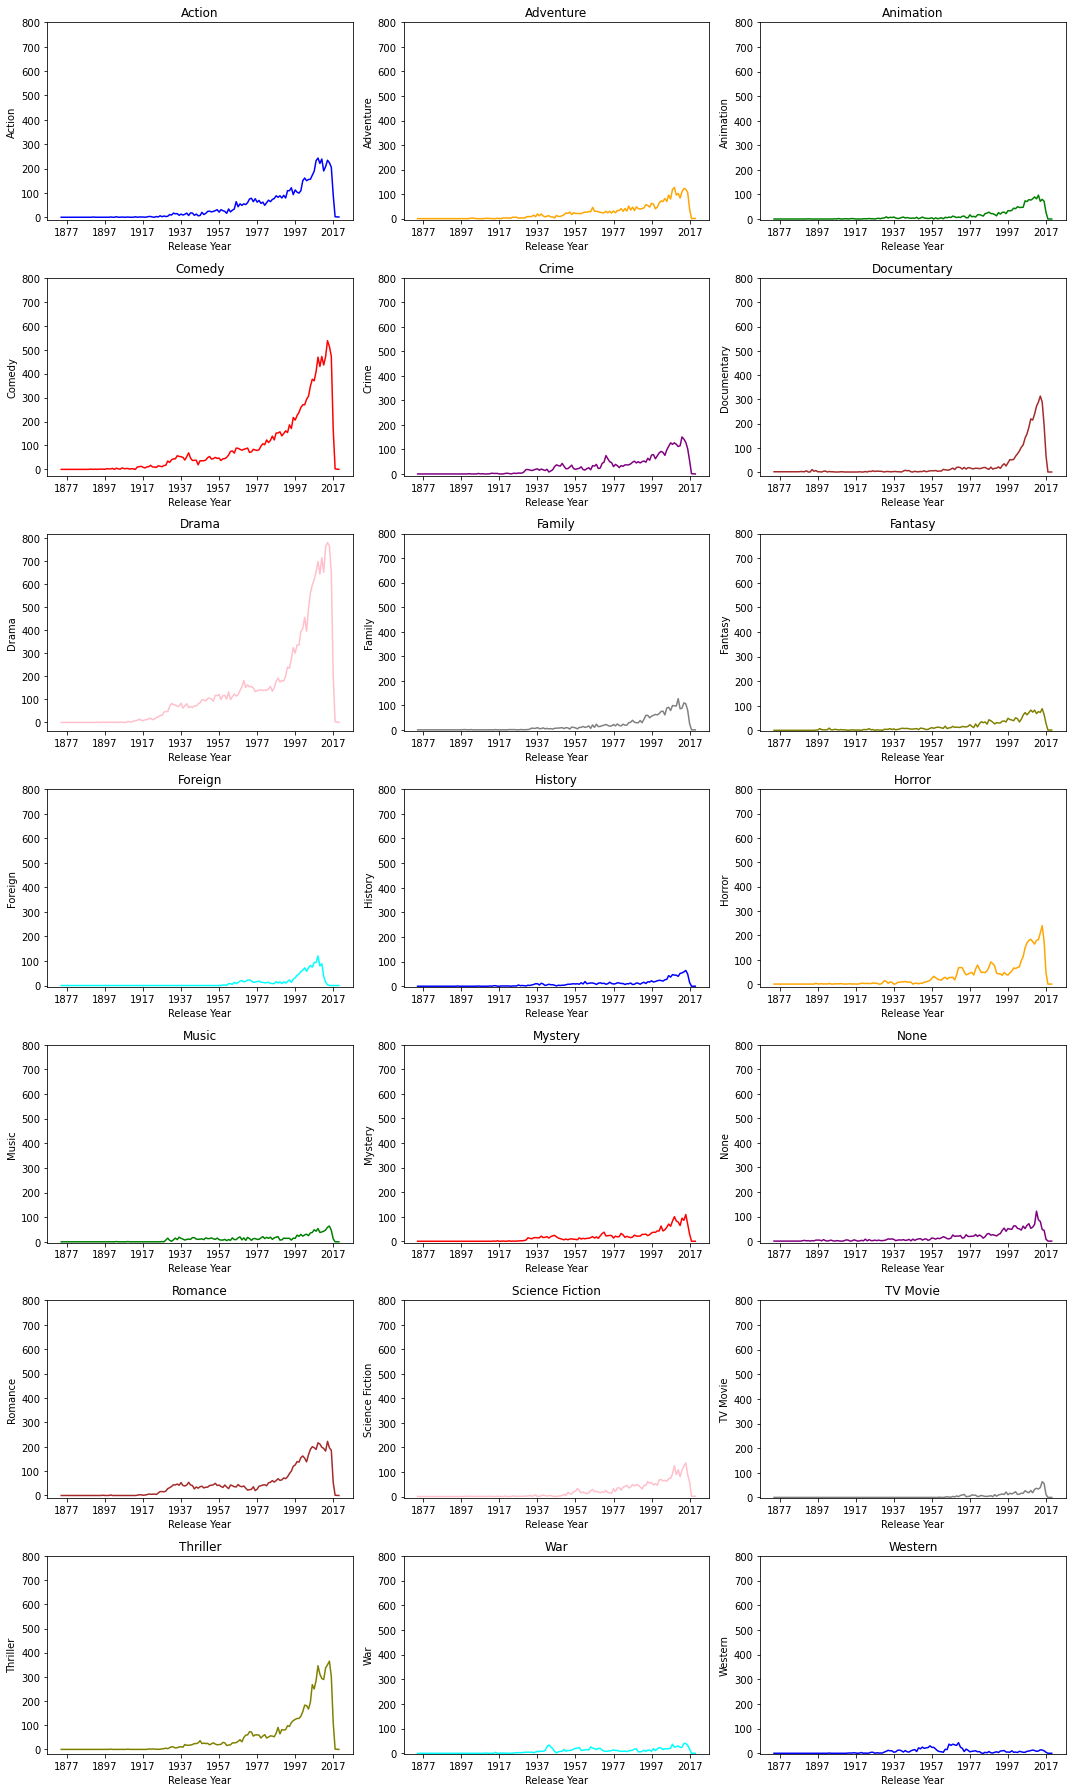

In [5]:
all_genres_ot = pd.DataFrame(index=np.unique(movies['release_date']), columns = genres_list)

# counting all genres over time
for year in all_genres_ot.index.values:
    count = []
    for g in genres_list:
        count.append(movies[movies['release_date'] == year]['genres'].sum().count(g))
    all_genres_ot.loc[year] = count

# make plot for each genre
plt.subplots(figsize=(15, 25))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'] * 3 + ['blue']

i = 1
for genrei in all_genres_ot:
    ## plot
    plt.subplot(7, 3, i)
    plt.plot(all_genres_ot.index, all_genres_ot[genrei], colors[i-1])
    plt.title(genrei)
    plt.xlabel("Release Year")
    plt.ylabel(genrei)
    plt.xticks(range(1877, 2020, 20))
    plt.yticks(range(0, 900, 100))
    
    i+=1

plt.tight_layout()
plt.show()

### Now lets find the most and least popular genre

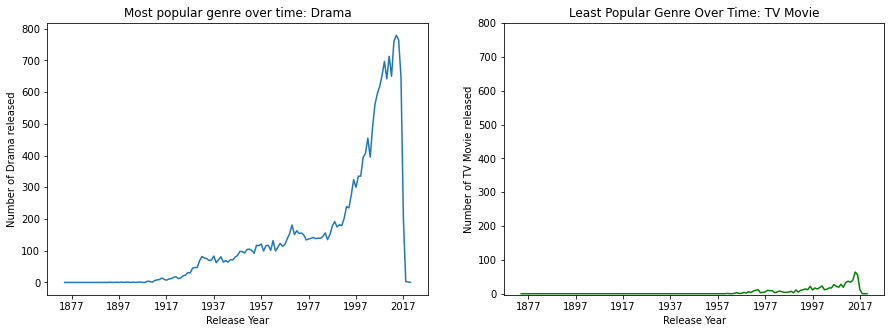

In [7]:
# find genre with most and least occurences 
most_popular_genre = genres_list[genre_counts.argmax()]
least_popular_genre = genres_list[genre_counts.argmin()]

# record occurences of most and least popular genre over time
all_genres = movies.groupby('release_date')['genres'].sum()

most = []
least = []
for i in np.unique(movies['release_date']):
    most.append(all_genres.loc[i].count(most_popular_genre))
    least.append(all_genres.loc[i].count(least_popular_genre))
    
movies_pop = pd.DataFrame(columns=['most_pop_ot', 'least_pop_ot'], index=all_genres.index)
movies_pop['most_pop_ot'] = most
movies_pop['least_pop_ot'] = least

## plot
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(movies_pop.index, movies_pop['most_pop_ot'])
plt.title('Most popular genre over time: ' + most_popular_genre)
plt.xlabel("Release Year")
plt.ylabel("Number of " + most_popular_genre + " released")
plt.xticks(range(1877, 2020, 20))

plt.subplot(1, 2, 2)
plt.plot(movies_pop.index, movies_pop['least_pop_ot'], 'g')
plt.title('Least Popular Genre Over Time: ' + least_popular_genre)
plt.xlabel("Release Year")
plt.ylabel("Number of " + least_popular_genre + " released")
plt.xticks(range(1877, 2020, 20))
plt.yticks(range(0, 900, 100))
plt.show()

### I saw some interesting patterns in the genres graphs, lets zoom in on a few

### Westerns

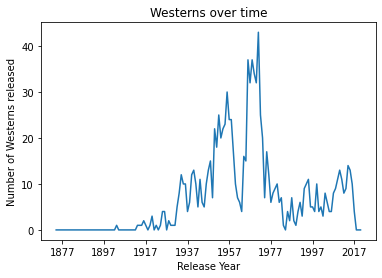

In [11]:
# plt.plot(movies_pop.index, movies_pop['most_pop_ot'])
plt.plot(all_genres_ot.index, all_genres_ot['Western'])
plt.title('Westerns over time' )
plt.xlabel("Release Year")
plt.ylabel("Number of Westerns released")
plt.xticks(range(1877, 2020, 20))
plt.show()

Western movies has a very interesting trend, because it becomes very popular around the 1950's, has a sudden decline for a few years, and then becomes very popular for a few years, then steadies out. I'm wondering if there was an event around 1960 that could have caused Westerns to not be produced for a few years.

### Horror

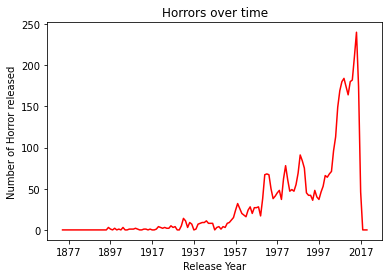

In [52]:
plt.plot(all_genres_ot.index, all_genres_ot['Horror'], 'r')
plt.title('Horrors over time' )
plt.xlabel("Release Year")
plt.ylabel("Number of Horror released")
plt.xticks(range(1877, 2020, 20))
plt.show()

Every few years horror movies gain popularity, and then procede to die down again. I'm not sure of any phemomenon that could cause this trend, but it is very interesting. The difference between those local maxima and minima is probably around 20 movies.

### Crime

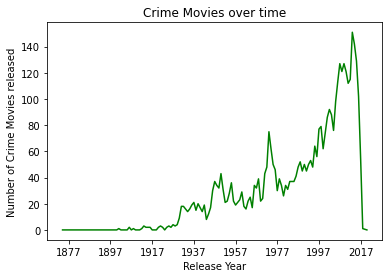

In [51]:
plt.plot(all_genres_ot.index, all_genres_ot['Crime'], 'g')
plt.title('Crime Movies over time' )
plt.xlabel("Release Year")
plt.ylabel("Number of Crime Movies released")
plt.xticks(range(1877, 2020, 20))
plt.show()

The crime genre is following a very similar pattern to horror movies, with a jump in popularity followed by a decline. It appears that the difference between the local maxima and minima is larger than Horrors, around 20-40.

## Analysis
Over the years many movies genres have gained popularity. Dramas are the most popular genres, there has been a steady increase in Dramas since the begining of film. Other genres such as Horror and Crime follow a pattern of jumps in popularity followed by a decline. And Westerns saw a single large production boom followed by a sudden drop.

I believe that Dramas are steadily produced compared to these other genres because a movie can have multiple genres. Drama tends to be the backbone to a lot of story lines, so a movie could be an action and a drama or maybe a romance and a drama. This versitility insures that drama will always be created. Westerns, Horror, and Crime movies appear to simply be trends for a period of time.